In [1]:
import pandas as pd
import json
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col, transform
from pyspark.sql.types import BooleanType, IntegerType, ArrayType, StringType

In [2]:
import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora, models
from nltk.stem import WordNetLemmatizer, SnowballStemmer
import nltk
from nltk.stem.porter import *
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/denis/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
spark = SparkSession \
        .builder \
        .master('local[*]') \
        .appName("PySpark for dblpv13") \
        .config("spark.driver.memory", "18g") \
        .config("spark.executor.memory", "18g") \
        .config("spark.driver.maxResultSize", "9g") \
        .getOrCreate()

In [4]:
tt = spark.read.parquet("results/data.parquet")

In [5]:
test = tt.sample(withReplacement=False, fraction=0.10, seed=117)
# test = tt

In [6]:
df = test.filter('old_id is not null and old_id != ""') \
        .filter('abstract is not null and abstract != ""') \
        .select(['old_id', 'title', 'abstract']).toPandas()

In [7]:
spark.stop()

In [8]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386884 entries, 0 to 386883
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   old_id    386884 non-null  object
 1   title     386884 non-null  object
 2   abstract  386884 non-null  object
dtypes: object(3)
memory usage: 8.9+ MB


/home/denis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  """Entry point for launching an IPython kernel.


In [9]:
df

,old_id,title,abstract
0,556fa0e92401b4b38c237451,Wire-Speed Differential SOAP Encoding,The use of SOAP based communication protocol i...
1,556fa5702401b4b38c23759d,Fusion of multitemporal and multiresolution re...,"In this paper, we propose a novel method to fu..."
2,556fa5822401b4b38c2375a3,Narrowband power line communications for mediu...,The aim of the paper is to show how narrowband...
3,556fa5b52401b4b38c2375b1,CMRR improvement for multichannel integrated r...,This paper presents Common Mode Rejection Rati...
4,556fa5dd2401b4b38c2375bb,Decongestion and vector difference based wavel...,Wavelength switching networks are circuit swit...
...,...,...,...
386879,607ead5fe4510cd7c8577020,Improved Monte Carlo Estimation of the Fisher ...,The Fisher information matrix provides a way t...
386880,607ead5fe4510cd7c8577025,On Stability of Automatic Generation Control,Automatic generation control (AGC) is one of t...
386881,607ead5fe4510cd7c857702b,An Improved Interest Point Detection Approach ...,Practical applications such as image registrat...
386882,60813dee91e011bce6b8ae64,"Identify, Align, and Integrate: Matching Knowl...",Integrating external knowledge into commonse...


In [10]:
# df.to_csv('results/part_data.csv', index=False, sep=';')

### Text

In [10]:
stemmer = SnowballStemmer(language='english')
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
#     return WordNetLemmatizer().lemmatize(text, pos='v')

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [11]:
row = df.iloc[1]
print(row['abstract'])
print('===')
print(' '.join(preprocess(row['abstract'])))

In this paper, we propose a novel method to fuse multidate, multiresolution, and multiband remote sensing imagery for multitemporal classification purposes. The proposed method is based on an explicit hierarchical graph-based model that is sufficiently flexible to deal with multisource coregistered time series of images collected at different spatial resolutions. An especially novel element of the proposed approach is the use of multiple quad-trees in cascade, each associated with an image acquired at a different date, with the aim to characterize the temporal correlations associated with distinct images in an input time series. Experimental results are shown with multitemporal and multiresolution Pléiades data1.
===
paper propos novel method fuse multid multiresolut multiband remot sens imageri multitempor classif purpos propos method base explicit hierarch graph base model suffici flexibl deal multisourc coregist time seri imag collect differ spatial resolut especi novel element pro

In [12]:
df = df[['title', 'abstract']]

In [13]:
import warnings
import multiprocessing
from contextlib import closing
warnings.filterwarnings("ignore")

In [14]:
%%time

with closing(multiprocessing.Pool(16)) as pool:
    ready_corpus = pool.map(preprocess, df['title'] + ' ' + df['abstract'])

CPU times: user 6.05 s, sys: 1.4 s, total: 7.45 s
Wall time: 1min 3s


In [16]:
# %%time

# import gc

# n = 50000
# ready_corpus = []

# for i in range(100):
#     temp = pd.read_csv('results/all_data.csv', sep=';', header=None, skiprows=i*50000 + 1, nrows=50000)
#     with closing(multiprocessing.Pool(16)) as pool:
#         temp_ready_corpus = pool.map(preprocess, temp[1].apply(str) + ' ' + temp[2].apply(str))
#         ready_corpus.extend(temp_ready_corpus)
#         print(len(temp_ready_corpus), len(ready_corpus))

# # for i in range(100):
# #     temp = df[0:n].copy(deep=True)
# #     df = df[n:]
# #     with closing(multiprocessing.Pool(16)) as pool:
# #         temp_ready_corpus = pool.map(preprocess, temp['title'] + ' ' + temp['abstract'])
# #         ready_corpus += temp_ready_corpus
# #         print(i, (i+1)*n, len(temp_ready_corpus), len(ready_corpus))
# #         gc.collect()

In [15]:
df = None

In [16]:
len(ready_corpus)

386884

In [17]:
dictionary = gensim.corpora.Dictionary(ready_corpus)

In [18]:
len(dictionary)

215202

In [19]:
dictionary.filter_extremes(no_below=30, no_above=0.4, keep_n=10000)
len(dictionary)

10000

In [20]:
%%time

with closing(multiprocessing.Pool(16)) as pool:
    bow_corpus = pool.map(dictionary.doc2bow, ready_corpus)

CPU times: user 10.1 s, sys: 2.37 s, total: 12.4 s
Wall time: 12.6 s


In [21]:
len(bow_corpus)

386884

In [22]:
%%time

tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

CPU times: user 2.74 s, sys: 6.92 ms, total: 2.75 s
Wall time: 2.75 s


In [25]:
%%time

lda_model = gensim.models.LdaMulticore(
    bow_corpus,
    num_topics=10,
    id2word=dictionary,
    passes=5,
    iterations=10,
    workers=8
)

CPU times: user 1min 10s, sys: 8.35 s, total: 1min 18s
Wall time: 1min 8s


In [26]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.019*"user" + 0.016*"data" + 0.014*"servic" + 0.012*"inform" + 0.010*"manag" + 0.009*"applic" + 0.008*"provid" + 0.008*"develop" + 0.008*"social" + 0.007*"model"
Topic: 1 
Words: 0.040*"model" + 0.012*"system" + 0.010*"agent" + 0.009*"approach" + 0.009*"robot" + 0.009*"program" + 0.009*"control" + 0.008*"process" + 0.008*"logic" + 0.008*"languag"
Topic: 2 
Words: 0.036*"problem" + 0.032*"algorithm" + 0.026*"optim" + 0.018*"graph" + 0.012*"time" + 0.010*"number" + 0.010*"result" + 0.010*"comput" + 0.009*"solut" + 0.008*"solv"
Topic: 3 
Words: 0.024*"method" + 0.015*"estim" + 0.013*"control" + 0.012*"propos" + 0.011*"model" + 0.011*"linear" + 0.010*"time" + 0.009*"function" + 0.009*"paramet" + 0.009*"error"
Topic: 4 
Words: 0.024*"imag" + 0.012*"method" + 0.010*"propos" + 0.008*"detect" + 0.008*"motion" + 0.008*"result" + 0.007*"track" + 0.007*"signal" + 0.007*"estim" + 0.007*"algorithm"
Topic: 5 
Words: 0.013*"test" + 0.010*"power" + 0.009*"model" + 0.009*"design" + 0.

In [ ]:
%%time

lda_model_2 = gensim.models.LdaMulticore(
    corpus_tfidf,
    num_topics=10,
    id2word=dictionary,
    passes=5,
    iterations=10,
    workers=8
)

In [ ]:
for idx, topic in lda_model_2.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

In [27]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=ready_corpus,
                                     dictionary=dictionary,
#                                      coherence='c_v',
                                     coherence='u_mass',
                                    processes=8)

In [28]:
coherence_lda = coherence_model_lda.get_coherence()

In [29]:
print(f'Coherence Score: {coherence_lda}')

Coherence Score: -1.9913886876018942


In [30]:
def compute_coherence_values(corpus, ready_corpus, dictionary, k, a, b):
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
#                                            chunksize=100,
                                           passes=3,
                                           iterations=50,
                                           chunksize = 5000,
                                           alpha=a,
                                           eta=b,
                                           workers=16)
    
    coherence_model_lda = CoherenceModel(model=lda_model,
#                                          texts=ready_corpus,
                                         corpus=corpus,
                                         dictionary=dictionary,
#                                          coherence='c_v',
                                         coherence='u_mass',
                                        processes=8)
    return coherence_model_lda.get_coherence()

In [ ]:
import numpy as np
from tqdm import tqdm_notebook
grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 2
max_topics = 20
step_size = 1
# topics_range = list(range(min_topics, max_topics, step_size))
# topics_range.extend(list(range(23, 45, 3)))
topics_range = [4, 7, 8, 9]

# Alpha parameter
# alpha = list(np.arange(0.01, 1, 0.5))
# alpha.append('symmetric')
alpha = []
alpha.append('asymmetric')
# alpha = ['auto',]

# Beta parameter
# beta = list(np.arange(0.01, 1, 0.5))
beta = ['auto',]
# beta.append(None)
# beta = ['auto',]

# Validation sets
num_of_docs = len(bow_corpus)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
#                gensim.utils.ClippedCorpus(corpus, num_of_docs*0.75), 
               corpus_tfidf]
corpus_title = ['75% Corpus', '100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm_notebook(total=len(corpus_sets) * len(topics_range) * len(alpha) * len(beta))
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], ready_corpus=ready_corpus,
                                                  dictionary=dictionary, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
                    pd.DataFrame(model_results).to_csv('results/lda_tuning_results.csv', index=False, sep=';')
    
    pd.DataFrame(model_results).to_csv('results/lda_tuning_results.csv', index=False, sep=';')
    pbar.close()

  0%|          | 0/4 [00:00<?, ?it/s]

### Check results                       

In [25]:
import pandas as pd
import json
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline

In [26]:
res = pd.read_csv('results/lda_tuning_results_10_big.csv', sep=';')

In [27]:
res

,Validation_Set,Topics,Alpha,Beta,Coherence
0,75% Corpus,2,0.01,NaN,-1.696129
1,75% Corpus,2,0.51,NaN,-1.784050
2,75% Corpus,2,asymmetric,NaN,-1.985348
3,75% Corpus,3,0.01,NaN,-1.812634
4,75% Corpus,3,0.51,NaN,-1.932094
5,75% Corpus,3,asymmetric,NaN,-4.606767
6,75% Corpus,4,0.01,NaN,-2.054624
7,75% Corpus,4,0.51,NaN,-2.030367
8,75% Corpus,4,asymmetric,NaN,-7.202950
9,75% Corpus,5,0.01,NaN,-1.923031


In [28]:
res_b = res[res['Alpha'] == 'asymmetric']
res_b

,Validation_Set,Topics,Alpha,Beta,Coherence
2,75% Corpus,2,asymmetric,NaN,-1.985348
5,75% Corpus,3,asymmetric,NaN,-4.606767
8,75% Corpus,4,asymmetric,NaN,-7.202950
11,75% Corpus,5,asymmetric,NaN,-6.515765
14,75% Corpus,6,asymmetric,NaN,-9.470158
17,75% Corpus,7,asymmetric,NaN,-6.565895
20,75% Corpus,8,asymmetric,NaN,-7.371811
23,75% Corpus,9,asymmetric,NaN,-5.814178
26,75% Corpus,10,asymmetric,NaN,-4.713313
29,75% Corpus,11,asymmetric,NaN,-5.382199


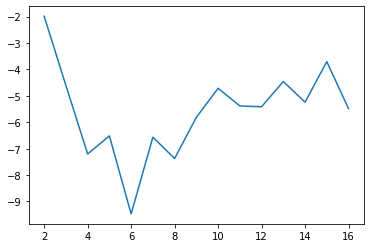

In [29]:
plt.plot(res_b['Topics'], res_b['Coherence'])

#### ^ проблема (6-топиков - мало, "глазами" разбиение на большое количество тем смотрится лучше) видимо в текстах на других языках (не английский)

In [23]:
import gc

In [24]:
bow_corpus = None
df = None

gc.collect()

80

In [25]:
lda_model = gensim.models.LdaMulticore(corpus=corpus_tfidf,
                                       id2word=dictionary,
                                       num_topics=20, 
                                       random_state=100,
                                       passes=3,
                                       iterations=50,
                                       chunksize = 5000,
                                       alpha='asymmetric',
                                       eta=None,
                                       workers=16)

coherence_model_lda = CoherenceModel(model=lda_model,
                                     corpus=corpus_tfidf,
                                     dictionary=dictionary,
                                     coherence='u_mass',
                                    processes=8)
coh = coherence_model_lda.get_coherence()
coh

-5.057877065305198

In [27]:
from gensim.test.utils import datapath

dict_path = 'results/lda_model/model_dict'
dictionary.save(dict_path)

model_file = datapath("/home/denis/dshibitov/courses/made/project_1/results/lda_model/model")
lda_model.save(model_file)

In [40]:
words_6 = pd.DataFrame()

for i in range(6):
    words = [dictionary[x[0]] for x in lda_model.get_topic_terms(i, topn=30)]
#     print([dictionary[x[0]] for x in lda_model.get_topic_terms(i, topn=30)])
    words_6 = words_6.append({'topic': i, 'words': ' '.join(words)}, ignore_index=True)

    words_6.to_csv('results/words_6.csv', index=False, sep=';')
words_6

,topic,words
0,0.0,network model algorithm control method data ti...
1,1.0,servic user data model learn network manag inf...
2,2.0,imag graph method algorithm featur estim segme...
3,3.0,vote ein hypergraph werden wird mirna voter ob...
4,4.0,diabet handoff weld cathet dedupl wifi graphen...
5,5.0,subdivis rendezv persona keyfram xpath spray l...


In [43]:
for i in range(6):
    print(words_6.iloc[i]['words'])
    print('=====')

network model algorithm control method data time problem optim perform propos system design power approach simul scheme function process comput detect channel analysi result estim applic present techniqu imag high
=====
servic user data model learn network manag inform develop system agent research design softwar mobil game applic technolog social process resourc secur languag knowledg environ interact approach provid support cloud
=====
imag graph method algorithm featur estim segment classif learn object problem propos detect recognit data point model color local edg cluster filter train function dataset nois sampl space label reconstruct
=====
vote ein hypergraph werden wird mirna voter obfusc elect einer sich durch jam phish zusammenfassung sind rung kutta crowdsens auch jammer nicht dieser beitrag oder dass dies einem einen spinal
=====
diabet handoff weld cathet dedupl wifi graphen harq seam retinopathi zigbe firewal ablat insulin toeplitz chat urllc comic vandermond resiz compan

In [46]:
words_20 = pd.DataFrame()

for i in range(20):
    words = [dictionary[x[0]] for x in lda_model.get_topic_terms(i, topn=30)]
#     print([dictionary[x[0]] for x in lda_model.get_topic_terms(i, topn=30)])
    words_20 = words_20.append({'topic': i, 'words': ' '.join(words)}, ignore_index=True)

    words_20.to_csv('results/words_20.csv', index=False, sep=';')
words_20

,topic,words
0,0.0,model network algorithm design data time metho...
1,1.0,model logic languag program fuzzi problem algo...
2,2.0,imag method featur learn data algorithm model ...
3,3.0,student learn social research user inform data...
4,4.0,network traffic mobil wireless servic packet d...
5,5.0,network resourc servic cloud data schedul appl...
6,6.0,imag robot motion camera human method track ob...
7,7.0,graph problem algorithm optim solut approxim s...
8,8.0,channel cod interfer relay antenna scheme mimo...
9,9.0,control stabil nonlinear system delay linear e...


In [47]:
for i in range(20):
    print(words_20.iloc[i]['words'])
    print('=====')

model network algorithm design data time method control process perform circuit system power simul comput propos applic test implement approach optim function present problem imag analysi high techniqu architectur parallel
=====
model logic languag program fuzzi problem algorithm agent system control semant method time approach function data rule theori type network optim comput order object structur learn relat process general inform
=====
imag method featur learn data algorithm model classif estim propos detect train network cluster recognit neural segment approach sampl dataset classifi object problem perform function extract accuraci label measur deep
=====
student learn social research user inform data knowledg educ develop model technolog studi design interact game project languag process ontolog system support cours tool scienc experi softwar document approach onlin
=====
network traffic mobil wireless servic packet data protocol energi control power communic time video devic ro